In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader

#input transformation seqeunce
transform = transforms.Compose([
        transforms.Resize((28, 28)), #resize input to 28x28
        transforms.ToTensor(), #convert image to pytorch tensor [0, 1] range
        transforms.Normalize((0.5, ), (0.5, )) #normalize values to [-1, 1] range
])

#load traning and test FashionMNIST dataset
'''
root --> save location if download is needed#train --> what portion of the dataset to load (training or testing)
download --> download dataset if not present in root
transform --> apply transitions to each image as it is being accessed
'''
full_train_dataset = torchvision.datasets.FashionMNIST(
        root='./data', train=True, download=True, transform=transform
)

test_dataset = torchvision.datasets.FashionMNIST(
        root='./data', train=False, download=True, transform=transform
)

#Split training dataset into training and validation sets (80%/20%)
train_size = int(0.8 * len(full_train_dataset))
val_size = int(0.2 * len(full_train_dataset))
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

#Create DataLoaders
'''
batch_size --> each batch retreived by the loader will get 512 samples at once
        - reduces gradient noise
        - allows parallel computing by GPU
        - forward pass --> CEL --> backward pass --> Gradient update
shuffle --> shuffle order samples are loaded
        - shuffle for training set to prevent overfitting
        - no shuffle for validation and testing set to ensure consistent & reproducible evaluation
num_workers --> how many parallel processes will be handling data loading
'''
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=2)

print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")



Train: 48000 | Val: 12000 | Test: 10000


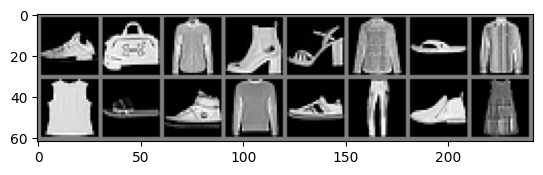

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Function to unnormalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Display the images in a grid along with their labels
imshow(torchvision.utils.make_grid(images[:16]))

In [7]:
import torch.nn.functional as F

class FashionMNISTNet(nn.Module):
        '''
        input: 28x28
        conv1 = 32x28x28
        maxpool = 32x14x14
        conv2 = 64x16x16
        maxpool = 64x8x8
        conv3 = 64x8x8
        maxpool = 64x4x4
        flatten = 1024
        '''
        def __init__(self):
                super(FashionMNISTNet, self).__init__()
                self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
                self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=2)
                self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
                self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
                self.fc1 = nn.Linear(in_features=1024, out_features=256)
                self.fc2 = nn.Linear(in_features=256, out_features=128)
                self.fc3 = nn.Linear(in_features=128, out_features=10)

        def forward(self, x):
                x = self.pool(F.relu(self.conv1(x)))
                x = self.pool(F.relu(self.conv2(x)))
                x = self.pool(F.relu(self.conv3(x)))
                x = torch.flatten(x, start_dim=1)
                x = F.relu(self.fc1(x))
                x = F.relu(self.fc2(x))
                x = self.fc3(x) #no ReLU on the last fully connected layer
                x = F.softmax(x, dim=1)
                return x
        
net = FashionMNISTNet()
print(net)

FashionMNISTNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
net.to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1)

no_validation_set_path = "no_validation_set.pth"

# Training loop (no validation)
num_epochs = 10
for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader, 0):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

        avg_loss = running_loss / (i + 1)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

#Test
correct = 0
total = 0

# Disable gradient calculation
with torch.no_grad():
    for inputs, labels in test_loader:

        # Move the inputs and labels to the GPU if available
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = net(inputs)

        # Get the predicted class
        _, predicted = torch.max(outputs.data, 1)

        # Update the total number of samples and correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate the accuracy
accuracy = 100 * correct / total
print(f"Accuracy: {accuracy:.2f}%")


Using device: cpu
Epoch [1/10], Loss: 2.3024
Epoch [2/10], Loss: 2.3021
Epoch [3/10], Loss: 2.3016
Epoch [4/10], Loss: 2.3010
Epoch [5/10], Loss: 2.2997
Epoch [6/10], Loss: 2.2968
Epoch [7/10], Loss: 2.2809
Epoch [8/10], Loss: 2.0451
Epoch [9/10], Loss: 1.8723
Epoch [10/10], Loss: 1.8045
Accuracy: 64.09%
